Bank Deposit UCI Dataset Exercise - Customer Deposit Predictive Analysis

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC

In [4]:
# Load dataset
# url = 'https://github.com/lin-meng/dsipy/blob/master/bank-full.csv'
BankDs = pd.read_csv('C:\\Users\\Meng\\OneDrive\\Documents\\tamu\\DataScience\\bank\\bank-full.csv', sep=';', na_values=['.'])

In [5]:
# shape
print(BankDs.shape) 

(45211, 17)


In [6]:
# head
print(BankDs.head(10))

   age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur   married  secondary      no        2     yes  yes   
3   47   blue-collar   married    unknown      no     1506     yes   no   
4   33       unknown    single    unknown      no        1      no   no   
5   35    management   married   tertiary      no      231     yes   no   
6   28    management    single   tertiary      no      447     yes  yes   
7   42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8   58       retired   married    primary      no      121     yes   no   
9   43    technician    single  secondary      no      593     yes   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may     

In [7]:
# check current data type
BankDs.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [8]:
# Dataset Info
BankDs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
# descriptions
BankDs.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [11]:
# dataset groupby job
print(BankDs.groupby('job').size())

job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
dtype: int64


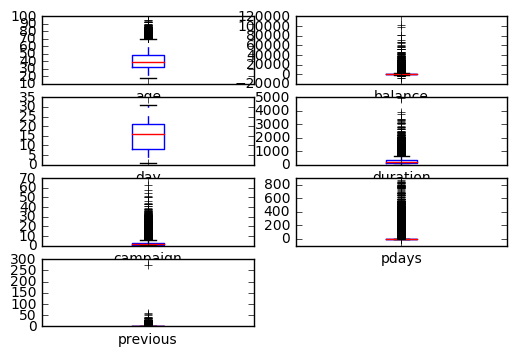

In [12]:
# box and whisker plots
BankDs.plot(kind='box', subplots=True, layout=(4,2), sharex=False, sharey=False)
plt.show()

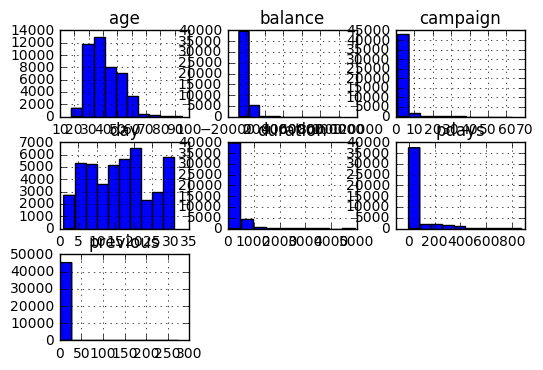

In [13]:
# histograms
BankDs.hist()
plt.show()

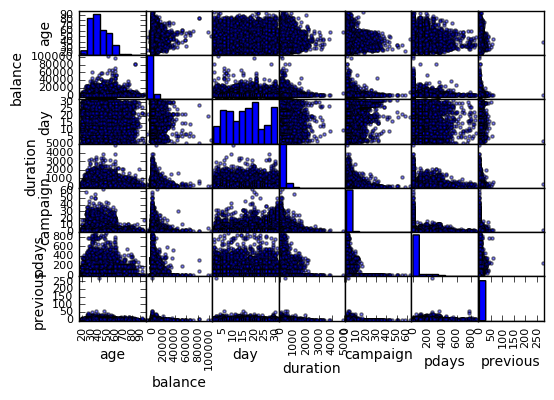

In [14]:
# scatter plot matrix
from pandas.tools.plotting import scatter_matrix
scatter_matrix(BankDs)
plt.show()

In [15]:
# add "Yes" column: 1 represents made a deposit, 0 represents did not make a deposit
BankDs['Yes'] = (BankDs.y =='yes').astype(int)

In [16]:
# Data Exploration by Yes
BankDs.groupby('Yes').mean()

,age,balance,day,duration,campaign,pdays,previous
Yes,,,,,,,
0,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
1,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


In [17]:
# Data Exploration by job
BankDs.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous,Yes
job,,,,,,,,
admin.,39.289886,1135.838909,15.564301,246.896732,2.575324,47.859021,0.671630,0.122027
blue-collar,40.044081,1078.826654,15.442561,262.901562,2.816995,44.033498,0.505138,0.072750
entrepreneur,42.190989,1521.470074,15.702085,256.309348,2.799597,32.486214,0.478144,0.082717
housemaid,46.415323,1392.395161,16.002419,245.825000,2.820968,21.505645,0.371774,0.087903
management,40.449567,1763.616832,16.114189,253.995771,2.864348,38.665468,0.668006,0.137556
retired,61.626767,1984.215106,15.439488,287.361307,2.346731,37.443905,0.638693,0.227915
self-employed,40.484484,1647.970868,16.027866,268.157061,2.853072,34.747308,0.551615,0.118429
services,38.740250,997.088108,15.635532,259.318729,2.718344,41.995185,0.501204,0.088830
student,26.542644,1388.060768,14.897655,246.656716,2.299574,57.041578,0.953092,0.286780


In [19]:
# show plots in the notebook
%matplotlib inline

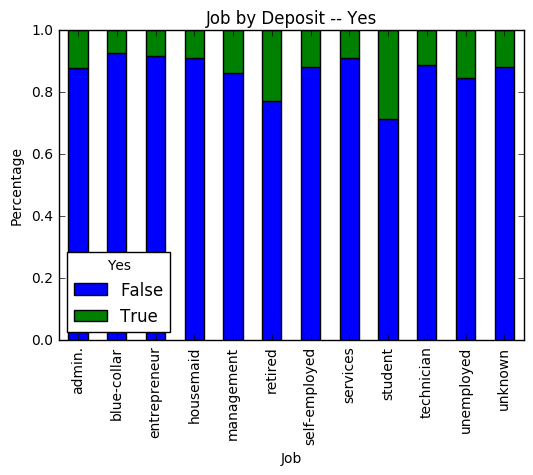

In [20]:
# Let's see job type by Deposite Yes
Yes_job_type = pd.crosstab(BankDs.job, BankDs.Yes.astype(bool))
Yes_job_type.div(Yes_job_type.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Job by Deposit -- Yes')
plt.xlabel('Job')
plt.ylabel('Percentage')

In [21]:
# Data Exploration by Education
BankDs.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous,Yes
education,,,,,,,,
primary,45.865567,1250.949934,15.421398,255.933002,2.834331,36.081740,0.489272,0.086265
secondary,39.964270,1154.880786,15.759159,258.685760,2.700802,42.353504,0.567753,0.105594
tertiary,39.593640,1758.416435,16.086535,258.518532,2.825577,39.024134,0.661980,0.150064
unknown,44.510501,1526.754443,15.810985,257.313947,2.849219,36.856220,0.488422,0.135703


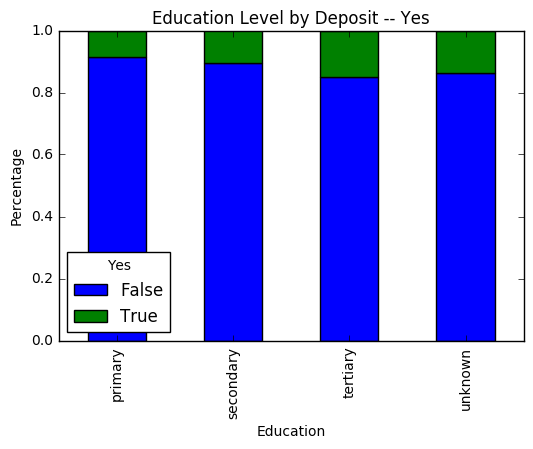

In [22]:
# Let's see education level by Deposite Yes
Yes_Ed_type = pd.crosstab(BankDs.education, BankDs.Yes.astype(bool))
Yes_Ed_type.div(Yes_Ed_type.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Education Level by Deposit -- Yes')
plt.xlabel('Education')
plt.ylabel('Percentage')

In [23]:
# Data Exploration by Marital Status
BankDs.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous,Yes
marital,,,,,,,,
divorced,45.782984,1178.872287,15.796428,262.517188,2.630882,41.001728,0.551373,0.119455
married,43.408099,1425.925590,15.854487,253.412765,2.842875,37.950467,0.556552,0.101235
single,33.703440,1301.497654,15.708210,266.497967,2.649805,44.652385,0.642690,0.149492


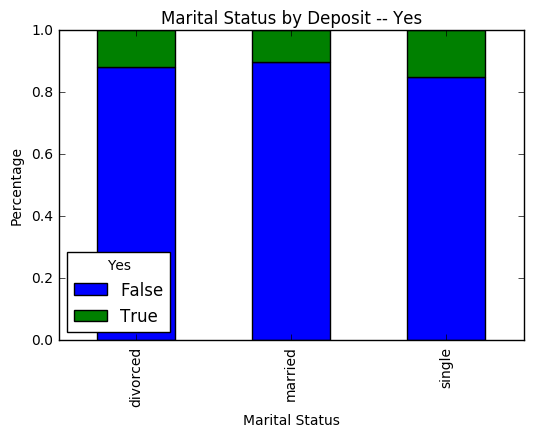

In [24]:
# Let's see marital status by Deposite Yes
Yes_Mari_type = pd.crosstab(BankDs.marital, BankDs.Yes.astype(bool))
Yes_Mari_type.div(Yes_Mari_type.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Marital Status by Deposit -- Yes')
plt.xlabel('Marital Status')
plt.ylabel('Percentage')

In [25]:
# create dataframes with an intercept column and dummy variables 
y, X = dmatrices('Yes ~ age + job + marital + default + balance + housing + loan + \
                 contact + day + month + duration + campaign + pdays + previous + poutcome', BankDs, return_type="dataframe")
print (X.columns)

Index(['Intercept', 'job[T.blue-collar]', 'job[T.entrepreneur]',
       'job[T.housemaid]', 'job[T.management]', 'job[T.retired]',
       'job[T.self-employed]', 'job[T.services]', 'job[T.student]',
       'job[T.technician]', 'job[T.unemployed]', 'job[T.unknown]',
       'marital[T.married]', 'marital[T.single]', 'default[T.yes]',
       'housing[T.yes]', 'loan[T.yes]', 'contact[T.telephone]',
       'contact[T.unknown]', 'month[T.aug]', 'month[T.dec]', 'month[T.feb]',
       'month[T.jan]', 'month[T.jul]', 'month[T.jun]', 'month[T.mar]',
       'month[T.may]', 'month[T.nov]', 'month[T.oct]', 'month[T.sep]',
       'poutcome[T.other]', 'poutcome[T.success]', 'poutcome[T.unknown]',
       'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
      dtype='object')


In [26]:
# flatten y into a 1-D array
y = np.ravel(y)

In [27]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.90186016677357284

In [28]:
# what percentage of Yes?
y.mean()

0.11698480458295547

<I>11.7 % of the customers took the deposit offer </I>, which means that we could obtain 88.3 % accuracy by always predicting "no". So we're doing slightly better than the null error rate, but not by much.
Let's examine the coefficients to see what we learn.

In [29]:
# examine the coefficients
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-0.844827556395]
1,job[T.blue-collar],[-0.360799490357]
2,job[T.entrepreneur],[-0.260309461316]
3,job[T.housemaid],[-0.442610781306]
4,job[T.management],[-0.0108010985603]
5,job[T.retired],[0.365164682453]
6,job[T.self-employed],[-0.189998206282]
7,job[T.services],[-0.208012120505]
8,job[T.student],[0.381667928148]
9,job[T.technician],[-0.140389260786]


In [30]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print (predicted)

[ 0.  1.  0. ...,  0.  0.  0.]


In [32]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print (probs)

[[ 0.99385106  0.00614894]
 [ 0.19959213  0.80040787]
 [ 0.97788496  0.02211504]
 ..., 
 [ 0.99122444  0.00877556]
 [ 0.95762001  0.04237999]
 [ 0.93428329  0.06571671]]


In [33]:
# generate evaluation metrics
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

0.899587142436
0.898385091476


In [34]:
print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

[[11645   324]
 [ 1038   557]]
             precision    recall  f1-score   support

        0.0       0.92      0.97      0.94     11969
        1.0       0.63      0.35      0.45      1595

avg / total       0.88      0.90      0.89     13564



In [35]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print (scores)
print (scores.mean())

[ 0.88942946  0.90446705  0.8805574   0.87126742  0.89537713  0.87967264
  0.8407432   0.61844725  0.90223402  0.70929204]
0.839148759025


In [36]:
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print(fit.n_features_)
print(fit.support_)
print(fit.ranking_)

3
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False  True False False  True False False False False
 False False False False]
[ 5 20 27 15 24 16 33 29 11 31 23 21 18 26 22  6 14 17  4  8  3 13  7  9 25
  1 12 10  1  2 19  1 30 36 38 34 35 28 37 32]


In [37]:
model = model.fit(X, y)
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_),fit.ranking_)))

,0,1,2
0,Intercept,[-0.844827556395],5
1,job[T.blue-collar],[-0.360799490357],20
2,job[T.entrepreneur],[-0.260309461316],27
3,job[T.housemaid],[-0.442610781306],15
4,job[T.management],[-0.0108010985603],24
5,job[T.retired],[0.365164682453],16
6,job[T.self-employed],[-0.189998206282],33
7,job[T.services],[-0.208012120505],29
8,job[T.student],[0.381667928148],11
9,job[T.technician],[-0.140389260786],31
